In [6]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from transformers import pipeline
from textblob import TextBlob
import flair
import nltk
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline

nltk.download('vader_lexicon')
nltk.download('punkt')

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
sia = SentimentIntensityAnalyzer()
nlp_transformers = pipeline("sentiment-analysis")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
def sentiment_analysis_glob(text):
    # Sentiment (global)

    sentiment_1 = TextBlob(text).sentiment[0] # TextBlob

    sentiment_2 = sia.polarity_scores(text)["compound"] # NLTK Vader

    try:
        transformers_result = nlp_transformers(text)[0] # BERT
        label_value = 1 if transformers_result['label'] == "POSITIVE" else -1
        sentiment_3 = label_value * transformers_result['score']
    except:
        sentiment_3 = 0

    text_an = flair.data.Sentence(text) # Flair
    flair_sentiment.predict(text_an)
    label_value = 1 if text_an.labels[0].value == "POSITIVE" else -1
    sentiment_4 = label_value * text_an.labels[0].score
    sentiment = 0.35 * sentiment_1 + 0.35 * sentiment_2 + 0.15 * sentiment_3 + 0.15 * sentiment_4
    #sentiment = (sentiment_1 + sentiment_2) / 2

    return sentiment

def sentiment_analysis(text):
    # Sentiment (sentence by sentence)
    sent_trend = list()
    for sentence in tqdm(sent_tokenize(text)):
            sentiment_1 = TextBlob(sentence).sentiment[0] # TextBlob

            sentiment_2 = sia.polarity_scores(sentence)["compound"] # NLTK Vader

            transformers_result = nlp_transformers(sentence)[0] # BERT
            label_value = 1 if transformers_result['label'] == "POSITIVE" else -1
            sentiment_3 = label_value * transformers_result['score']

            sentence_an = flair.data.Sentence(sentence) # Flair
            flair_sentiment.predict(sentence_an)
            label_value = 1 if sentence_an.labels[0].value == "POSITIVE" else -1
            sentiment_4 = label_value * sentence_an.labels[0].score
            sentiment = 0.35 * sentiment_1 + 0.35 * sentiment_2 + 0.15 * sentiment_3 + 0.15 * sentiment_4
            #sentiment = (sentiment_1 + sentiment_2) / 2
            sent_trend.append((sentence, sentiment))

    sent_trend_df = pd.DataFrame(sent_trend, columns = ("sentence", "sentiment"))
    sent_trend_df['EMA'] = sent_trend_df['sentiment'].ewm(span = 15, adjust=False).mean()

    return sent_trend_df

def sliding_window(input_list, window_size):
    windows = list()
    for i in range(len(input_list)):
        start = max(0, i - window_size + 1)
        end = i + 1
        windows.append(input_list[start:end])

    return windows

In [5]:
text = """
In the distant future, Duke Leto Atreides, ruler of the planet Caladan, is assigned by the Padishah Emperor Shaddam IV to replace Baron Vladimir Harkonnen as the fiefholder of Arrakis, a harsh desert planet and sole source of "spice", a valuable psychotropic substance that imparts heightened vitality and awareness. Spice is key to interstellar travel, giving Spacing Guild Navigators the ability to guide starships to traverse space instantaneously and safely. Shaddam plots for House Harkonnen to retake Arrakis, secretly aided by his Sardaukar troops, to destroy House Atreides. Leto is suspicious of the Emperor but weighs the risks against the power of controlling Arrakis and making an alliance with its mysterious natives, the Fremen.

Leto's concubine, Lady Jessica, is an acolyte of the Bene Gesserit, an exclusive sisterhood whose members possess advanced physical and mental abilities. As part of their centuries-long breeding program, they instructed her to bear a daughter whose son would become the Kwisatz Haderach, a Bene Gesserit and messianic superbeing with the clairvoyance necessary to guide humanity to a better future. However, she disobeyed and bore a son, Paul. Throughout his life, he is trained by Leto's aides, Duncan Idaho, Gurney Halleck, Suk doctor Wellington Yueh, and the Mentat Thufir Hawat, while Jessica teaches him Bene Gesserit disciplines. Paul confides in Jessica and Duncan that he is troubled by visions of the future. In response to Paul's increasing prescience, the Reverend Mother and Imperial Truthsayer Gaius Helen Mohiam visits Caladan and subjects him to a death-alternative test to assess his humanity and impulse control, which he passes. Mohiam insists that Baron Harkonnen spare Paul and Jessica during his coup, to which he duplicitously agrees.

House Atreides arrives at Arrakeen, the fortress stronghold on Arrakis. Duncan's advance party has made contact with the Fremen. The natives revere Paul and Jessica, which Jessica explains is due to the Bene Gesserit sowing beliefs on Arrakis centuries earlier. Leto negotiates with Fremen chieftain, Stilgar, and meets the Imperial Judge of the Change, Dr. Kynes, a planetologist who lives among the Fremen. Kynes briefs them on the dangers of spice harvesting, and the giant sandworms which travel under the desert and make the use of protective Holtzman shields unwise. During a flight, they dramatically rescue a stranded spice-harvesting crew from a sandworm; Paul's exposure to the spice triggers intense premonitions.

An attempt to assassinate Paul with a hunter-seeker fails. Yueh betrays the Atreides and disables Arrakeen's shields, allowing the Harkonnens and Sardaukar to invade. He incapacitates Leto, planning to exchange him for his wife, who is the Baron's prisoner. Yueh replaces one of Leto's teeth with a poison gas capsule with which the Duke can assassinate the Baron. Leto releases the gas, killing himself and the Baron's Mentat, Piter De Vries, but the Baron survives. Though the Baron has arranged to have Paul and Jessica dropped deep in the desert to die, a compassionate Yueh has left them with stillsuits and other survival supplies. Jessica uses a Bene Gesserit technique called "the Voice" to overpower and kill their captors. Paul and Jessica journey overnight in the desert where Paul, surrounded by spice, has visions of a bloody "holy war" fought across the universe in his name.

Baron Harkonnen gives command of Arrakis to his nephew, Rabban, and orders him to restart spice production to recoup the cost of the invasion. Paul and Jessica are found by Duncan and Kynes, and Paul discloses his plan to marry one of Shaddam's daughters to avert the civil war that would ensue from news of the Emperor's treachery. They are found by the Sardaukar, and Duncan sacrifices himself to allow Paul and Jessica to escape. Kynes is mortally wounded by Sardaukar but summons a sandworm that devours them. In the deep desert, Paul and Jessica encounter Stilgar's tribe, including Chani, the girl in Paul's visions. Fremen warrior Jamis opposes Stilgar's lenience to them and challenges Paul to a ritual duel to the death, which Paul wins. Against Jessica's wishes, Paul joins the Fremen to fulfill his father's goal of bringing peace to Arrakis.
"""

In [10]:
tokens = sent_tokenize(text)

window_size = max(len(tokens), 5)
result = sliding_window(sent_tokenize(text), window_size)

In [11]:
sent_trend_df = sentiment_analysis(text)
sent_glob = [sentiment_analysis_glob(" ".join(subset)) for subset in tqdm(result)]

100%|██████████| 32/32 [00:44<00:00,  1.38s/it]


In [15]:
sent_trend_df["global_sentiment"] = sent_glob
sent_trend_df["corrected_sentiment"] = 0.5 * sent_trend_df["sentiment"] + 0.5 * sent_trend_df["global_sentiment"]

<ipython-input-19-8b1f43bdf6a0>:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap = "RdYlGn"), label = "Value")


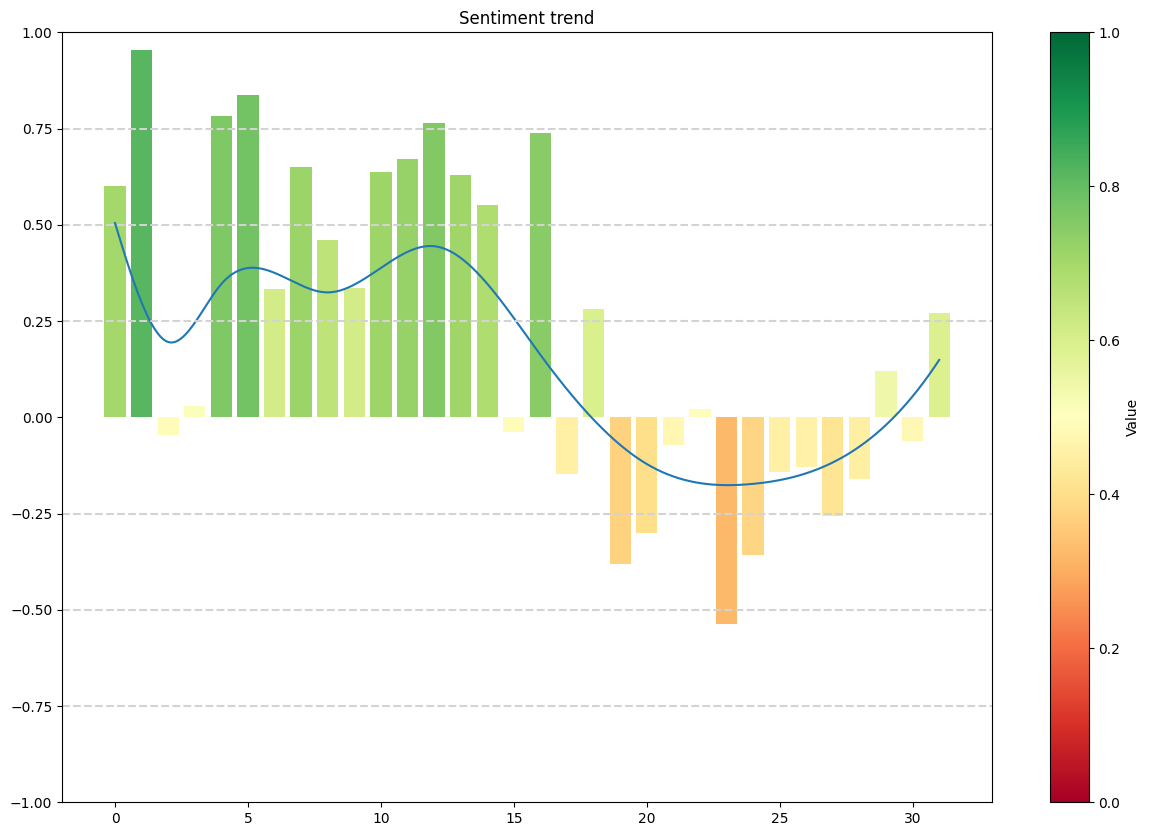

In [19]:
plt.figure(figsize = (15, 10))

colors = plt.cm.RdYlGn((np.array(sent_trend_df.corrected_sentiment) + 1) / 2.)

plt.bar(range(sent_trend_df.shape[0]), sent_trend_df.corrected_sentiment, color = colors)

plt.colorbar(plt.cm.ScalarMappable(cmap = "RdYlGn"), label = "Value")

# Spline
y = sent_trend_df.corrected_sentiment
x = np.arange(len(y))
spline = UnivariateSpline(x, y, s = 0.75)
x_smooth = np.linspace(x.min(), x.max(), 1000)
y_smooth = spline(x_smooth)

plt.plot(x_smooth, y_smooth)

values = [-0.75, -0.5, -0.25, 0.25, 0.5, 0.75]

for value in values:
    plt.axhline(y=value, color='lightgray', linestyle='--')

plt.ylim((-1, 1))
plt.title("Sentiment trend")
plt.show()